**[Pipeline Implementation]**

1. VLM Tool
2. Agentic object detection pipeline
3. Running the object detector
4. Why Numbered Batching for Inferencing
5. Critiquing and Refining the Query
6. Validation Bounding Box predictions utilizing the VLM

### 1. VLM Tool



* Input
    * Image(path/ base64)
    * User request
* Output
    * Object: [str]

In [39]:
import base64
import json
import base64, os, hashlib
import torch

from openai import OpenAI
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv

In [40]:
# util function
# 프로젝트 루트 탐색
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir

In [41]:
def encode_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

In [42]:
class VLMTool:
    def __init__(self, api_key):
        self.client = OpenAI(api_key=api_key)

    def chat_completion(
        self,
        messages,
        model="o1",
        max_tokens=300,
        temperature=0.1,
        response_format=None
    ):
        """Calls GPT for chat completion.
        return first message of GPTs"""
        try:
            if model in ["gpt-4o", "gpt-4o-mini"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    max_tokens=max_tokens,
                    temperature=temperature,
                    response_format=response_format if response_format else {"type": "text"}
                )
            elif model in ["o1"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    response_format=response_format if response_format else {"type": "text"}
                )
            else:
                raise NotImplementedError("This model is not supported")

            return response.choices[0].message.content

        except Exception as e:
            print(f"Error calling LLM: {e}")
            return None

    def extract_objects_from_request(self, image_path, user_text, model="gpt-4o"):
        """ Asks the LLM to parse user request for which objects to detect/segment.
        Returns a list of objects in plain text."""
        base64_image = encode_image(image_path) # image encoding 방식 변경 가능
        if not base64_image:
            return None

        prompt = (
            "You are an AI vision assistant that extracts objects to be identified from a user's request."
            "If the user wants to detect or semantically segment all objects in the image, return a comma-separated list of objects you can see. "
            "If the user wants to detect or semantically segment specific objects, extract only those mentioned explicitly in their request. "
            "Respond ONLY with the list of objects, separated by commas, and NOTHING ELSE."
            "The objective here is only to understand the objects of interest that can be extracted from the image and the user's request."
            "You are not actually required to perform or execute the user's request."    
            )

        messages = [
            {"role": "system", "content": prompt},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_text},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        }
                    }
                ]
            }
        ]

        result = self.chat_completion(messages, model=model)
        if result:
            detected_objects = [
                obj.strip().lower()
                for obj in result.split(",")
                if obj.strip()
            ]
            return detected_objects

        return []

In [43]:
"""
# chat_completion() 출력 예시 
import os
from dotenv import load_dotenv

project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path) # .env 파일의 환경 변수를 os.environ에 로드 / 환경변수 전부 로드

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)
chat_messages = [
    {"role": "system", "content": "You are a creative poet."},
    {"role": "user", "content": "Write a short poem about a lonely star."}
]

response = client.chat_completion(
    messages=chat_messages,
    model="gpt-4o",
    max_tokens=150,
    temperature=0.8
)
print(response)
"""

'\n# chat_completion() 출력 예시 \nimport os\nfrom dotenv import load_dotenv\n\nproject_root = find_project_root()\ndotenv_path = os.path.join(project_root, ".env")\nload_dotenv(dotenv_path) # .env 파일의 환경 변수를 os.environ에 로드 / 환경변수 전부 로드\n\napi_key = os.getenv("OPENAI_API_KEY")\nclient = VLMTool(api_key=api_key)\nchat_messages = [\n    {"role": "system", "content": "You are a creative poet."},\n    {"role": "user", "content": "Write a short poem about a lonely star."}\n]\n\nresponse = client.chat_completion(\n    messages=chat_messages,\n    model="gpt-4o",\n    max_tokens=150,\n    temperature=0.8\n)\nprint(response)\n'

In [44]:
# extract_objects_from_request() 출력 예시
project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)


image_path = r"C:\Users\KIST\agentic-object-detection\data\image1.jpg"

# Test1: 모든 객체 탐지
user_request_1 = "Find all objects in this picture."
objects_1 = client.extract_objects_from_request(image_path, user_request_1)
print(f"요청: {user_request_1}")
print(f"결과: {objects_1}")
print()


Error encoding image: [Errno 2] No such file or directory: 'C:\\Users\\KIST\\agentic-object-detection\\data\\image1.jpg'
요청: Find all objects in this picture.
결과: None



### 2. Agentic object detection pipeline

* Input
    * Image
    * Object labels
* Output
    * detection: [{bbox, score, label}]

=> for initial, final verification 

In [45]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import json

"""
from config import MODEL_TYPES, CONFIDENCE_THRESHOLD, INV_MODEL_TYPES
from utils.image_utils import draw_arrows_and_numbers, encode_image, draw_bounding_boxes
"""

class ObjectDetectionTool:
    """ 2. Agentic object detection pipeline"""
    """
    Performs object detection using GroundingDINO or OWL-ViT,
    plus an optional 'critique' (refinement) step with a VLM
    to yield a refined set of objects to detect.
    """
    def __init__(self, model_id, device, vlm_tool, confidence_threshold=0.2, concept_detection_model="gpt-4o", initial_critique_model="o1", final_critique_model="gpt-4o"):
        self.model_id = model_id
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        self.device = device
        self.vlm_tool = vlm_tool  # The LLMTool that can handle vision (GPT-4V) or similar
        self.confidence_threshold = confidence_threshold
        self.concept_detection_model = concept_detection_model
        self.initial_critique_model = initial_critique_model
        self.final_critique_model = final_critique_model
        
        # We store bounding boxes for potential usage later (e.g., for SAM).
        self.last_detection_bboxes = []
        self.last_filtered_objects = []
    


### 3. Running the Object Detector

* Input
    * Image
    * initial_detection
* Output
    * annotated_image

In [46]:
""" Configuration """
# Model configuration
MODEL_TYPES = {
    "owlvit": "google/owlvit-base-patch32",
    "grounding_dino": "IDEA-Research/grounding-dino-tiny",
}

INV_MODEL_TYPES = {v:k for k,v in MODEL_TYPES.items()}

DEFAULT_MODEL_TYPE = "grounding_dino"
MODEL_ID = MODEL_TYPES[DEFAULT_MODEL_TYPE]

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization
COLOR_PALETTE = [
    "red", "blue", "green", "purple", "orange", 
    "cyan", "magenta", "yellow", "brown", "pink"
]

# Threshold
CONFIDENCE_THRESHOLD = 0.2

In [47]:
import cv2
import base64
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def draw_arrows_and_numbers(image_path, detected_objects):
    """
    Draws arrows and numbers on an image to label detected objects.
    """
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    font = cv2.FONT_HERSHEY_SIMPLEX
    used_positions = []

    # Pad the image with a white border
    top, bottom, left, right = 50, 50, 50, 50
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    height, width, _ = img.shape

    for i, (num, obj, box) in enumerate(detected_objects):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # Center of the bounding box

        # Adjust coordinates for padded image
        x1 += left
        y1 += top
        x2 += left
        y2 += top
        cx += left
        cy += top

        # Determine arrow direction towards the nearest border
        distances = {'top': cy, 'bottom': height - cy, 'left': cx, 'right': width - cx}
        direction = min(distances, key=distances.get)

        if direction == 'top':
            arrow_end = (cx, top)
            text_position = (cx - 10, top - 10)
        elif direction == 'bottom':
            arrow_end = (cx, height - bottom)
            text_position = (cx - 10, height - 5)
        elif direction == 'left':
            arrow_end = (left, cy)
            text_position = (left - 30, cy + 5)
        else:
            arrow_end = (width - right, cy)
            text_position = (width - 30, cy + 5)

        # Draw the dashed arrow from the object center to the border
        color = (0, 0, 0)  # Black color for all arrows
        line_type = cv2.LINE_4
        cv2.arrowedLine(img, (cx, cy), arrow_end, color, 2, tipLength=0.3)

        # Draw a semi-transparent rectangle behind the text
        overlay = img.copy()
        cv2.rectangle(overlay, (text_position[0] - 5, text_position[1] - 20), (text_position[0] + 30, text_position[1] + 5), (0, 0, 0), -1)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

        # Draw the number at the border with black text
        cv2.putText(img, str(num), text_position, font, 0.5, color, 2)

    # Create dynamic output path based on input image path
    base_name = os.path.basename(image_path)
    name_part, ext_part = os.path.splitext(base_name)
    output_filename = f"labeled_objects_{name_part}{ext_part}"
    
    # Correctly construct the path relative to the notebook's location
    output_dir = os.path.join("..", "data", "output")
    os.makedirs(output_dir, exist_ok=True)
    labeled_image_path = os.path.join(output_dir, output_filename)
    
    cv2.imwrite(labeled_image_path, img)
    return labeled_image_path

In [48]:
def _run_detector(self, image_path, query_list):
    """
    Low-level routine to run the detection model on `query_list`.
    Returns: (detected_objects_final, labeled_image_path)
    Where `detected_objects_final` = [(num, label, [x1,y1,x2,y2]), ...].
    """
    from PIL import ImageFont
    
    # Format queries for the model
    if INV_MODEL_TYPES[self.model_id] == "owlvit":
        formatted_queries = [f"An image of {q}" for q in query_list]
    elif INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        formatted_queries = " ".join([f"{q}." for q in list(set(query_list))])
    else:
        raise NotImplementedError("Model not supported")

    # Load image
    img = Image.open(image_path).convert("RGB")
    inputs = self.processor(
        text=formatted_queries, 
        images=img, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    ).to(self.device)

    # PyTorch gradient 계산 비활성화
    self.model.eval()
    with torch.no_grad():
        outputs = self.model(**inputs)
    
    # Post-process bounding boxes
    if INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        results = self.processor.post_process_grounded_object_detection(
            outputs, 
            inputs.input_ids,
            target_sizes=[img.size[::-1]]
        )
        boxes = results[0]["boxes"]
        scores = results[0]["scores"]
        labels = results[0]["text_labels"]
    elif INV_MODEL_TYPES[self.model_id] == "owlvit":
        logits = torch.max(outputs["logits"][0], dim=-1)
        scores = torch.sigmoid(logits.values).cpu().numpy()
        labels = logits.indices.cpu().numpy()
        boxes = outputs["pred_boxes"][0].cpu().numpy()
    else:
        raise NotImplementedError("Model not supported")            

    detected_objects_final = []
    idx = 1
    for score, box, label in zip(scores, boxes, labels):
        if score < self.confidence_threshold:
            continue
        detected_objects_final.append((idx, label, box.tolist()))
        idx += 1

    # Draw numbers
    labeled_image_path = draw_arrows_and_numbers(image_path, detected_objects_final)
    return detected_objects_final, labeled_image_path

# 클래스에 메서드 추가
ObjectDetectionTool._run_detector = _run_detector

#### Exercise: detection + visualization 

In [49]:
# 환경 설정
project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)
api_key = os.getenv("OPENAI_API_KEY")

# VLMTool 초기화
vlm_tool = VLMTool(api_key=api_key)

# ObjectDetectionTool 초기화
detector = ObjectDetectionTool(
    model_id=MODEL_ID,  # "IDEA-Research/grounding-dino-tiny"
    device=DEVICE,      # "cuda" or "cpu"
    vlm_tool=vlm_tool,
    confidence_threshold=CONFIDENCE_THRESHOLD,  # 0.2
    concept_detection_model="gpt-4o",
    initial_critique_model="o1",
    final_critique_model="gpt-4o"
)

print(f"  - Model: {MODEL_ID}")
print(f"  - Device: {DEVICE}")
print(f"  - Confidence threshold: {CONFIDENCE_THRESHOLD}")

  - Model: IDEA-Research/grounding-dino-tiny
  - Device: cuda
  - Confidence threshold: 0.2


In [50]:
# === Object Detection ===
image_path = r"C:\Users\KIST\agentic-object-detection\data\input\image1.jpg"

# 사용자 요청에서 객체 추출 (VLM 사용)
user_request = "Detect all objects in this image"
objects_to_detect = vlm_tool.extract_objects_from_request(image_path, user_request)
print(f" List of Object: {objects_to_detect}")
print()

# detection
detected_objects, labeled_image_path = detector._run_detector(image_path, objects_to_detect)
print(f"🎯 Number of detected object: {len(detected_objects)}")
print(f"📁 Labeled image: {labeled_image_path}")
print()

# reult
print("상세 결과:")
for num, label, bbox in detected_objects:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] 레이블: {label}, 위치: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

 List of Object: ['tomatoes', 'leaves', 'plants', 'soil', 'pathway', 'support structures']

🎯 Number of detected object: 22
📁 Labeled image: ..\data\output\labeled_objects_image1.jpg

상세 결과:
  [1] 레이블: tomatoes, 위치: (103.6, 215.3, 157.1, 270.2)
  [2] 레이블: tomatoes, 위치: (55.0, 244.3, 111.2, 295.2)
  [3] 레이블: tomatoes, 위치: (153.7, 82.9, 196.7, 124.2)
  [4] 레이블: tomatoes, 위치: (111.6, 74.0, 165.4, 116.4)
  [5] 레이블: tomatoes, 위치: (185.2, 195.1, 220.1, 222.0)
  [6] 레이블: tomatoes, 위치: (143.8, 182.2, 186.1, 221.1)
  [7] 레이블: plants, 위치: (0.8, 0.6, 280.3, 339.9)
  [8] 레이블: pathway, 위치: (258.2, 112.7, 437.9, 340.1)
  [9] 레이블: tomatoes, 위치: (78.7, 7.6, 112.0, 39.0)
  [10] 레이블: tomatoes, 위치: (93.0, 323.5, 119.9, 340.5)
  [11] 레이블: tomatoes, 위치: (52.3, 3.0, 81.1, 31.1)
  [12] 레이블: support structures, 위치: (275.1, 1.1, 329.0, 77.3)
  [13] 레이블: plants, 위치: (273.1, 1.0, 511.3, 340.2)
  [14] 레이블: leaves, 위치: (41.6, 143.8, 98.4, 221.7)
  [15] 레이블: leaves, 위치: (23.5, 62.1, 72.0, 111.6)
  [16] 레이블: leaves,

원본 이미지:


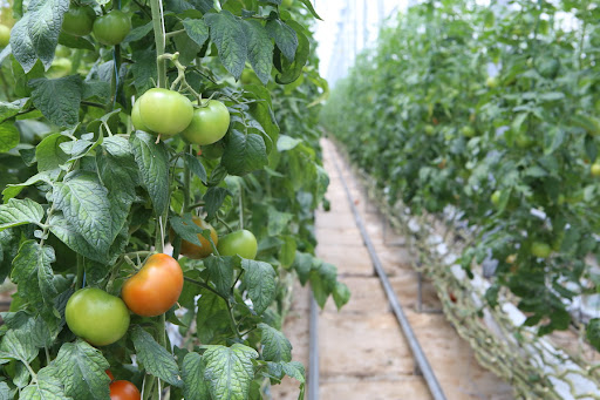


탐지 결과 이미지:


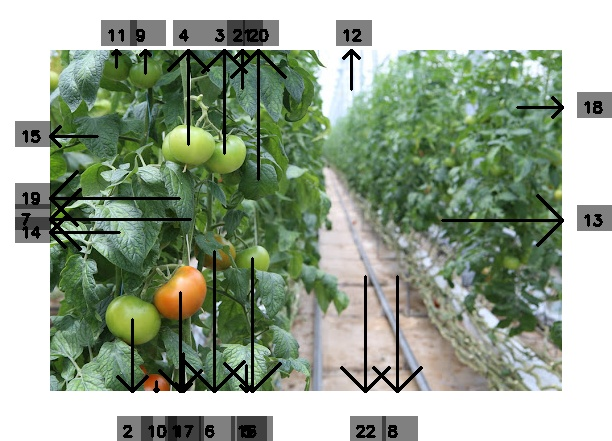

In [51]:
# === 결과 이미지 표시 ===

from PIL import Image
from IPython.display import display

# 원본 이미지
print("원본 이미지:")
original_img = Image.open(image_path)
display(original_img.resize((600, 400)))

# 탐지 결과 이미지
print("\n탐지 결과 이미지:")
labeled_img = Image.open(labeled_image_path)
display(labeled_img)

📋 특정 객체 탐지: ['green tomatoes are visible on the plants in the image.']
🎯 탐지된 객체 수: 4
📁 레이블 이미지: ..\data\output\labeled_objects_image1.jpg



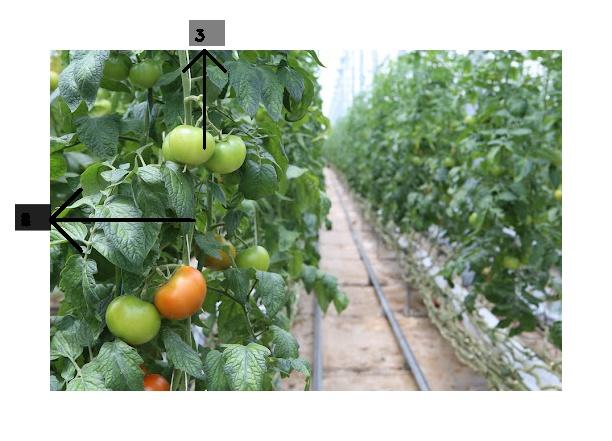

상세 결과:
  [1] 레이블: plants, 위치: (1.5, 1.4, 287.6, 339.4)
  [2] 레이블: green tomatoes, 위치: (7.2, 2.9, 233.8, 337.7)
  [3] 레이블: green, 위치: (110.3, 71.8, 198.4, 125.7)
  [4] 레이블: green tomatoes, 위치: (2.4, 1.7, 278.4, 338.7)


In [52]:
# === 특정 객체만 탐지 ===

user_request_specific = "Find green colored tomatoes in this picture"
specific_objects = vlm_tool.extract_objects_from_request(image_path, user_request_specific)
print(f"📋 특정 객체 탐지: {specific_objects}")

detected_specific, labeled_specific_path = detector._run_detector(image_path, specific_objects)
print(f"🎯 탐지된 객체 수: {len(detected_specific)}")
print(f"📁 레이블 이미지: {labeled_specific_path}")
print()


# 결과 표시
labeled_specific_img = Image.open(labeled_specific_path)
display(labeled_specific_img)

# 상세 결과 출력
print("상세 결과:")
for num, label, bbox in detected_specific:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] 레이블: {label}, 위치: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

### 4. Why Numbered Batching for Inferencing

* 목적: 이후 과정에서 VLM 호출 최적화

* Brute-force crop loop vs Numbered batching 
    * Brute-force crop loop
    
    * Numbered batching

### 5. Critiquing and Refining the Query

* 목적: initial detection의 결과가 미미할 때 '선택적'으로 '추가 연산'
* User request가 세분화된 라벨이라면 bbox가 threshold를 넘을 수 없으므로 해당 문제를 해결하기 위한 방식

* Input
    * annotated image(conclude arrow & numbered label) 
    * User request
    * initial detection

* Process
    * 실패한 케이스에 대하여 라벨이 구체적인지를 질문
    * 하의어를 포함하는 상의어로 변경 ex. 나뭇잎에 가려진 토마토 -> 토마토

* Output
    * refined concept
    - {"reasoning": "...", "refined_list": "dog, shoe, flower"} 같은 JSON


In [53]:
def _critique_and_refine_query(self, user_request, original_concepts, labeled_image_path, objects_detected, model="o1"):
        """
        Asks the VLM/LLM: "We tried to detect <objects_detected> for the user request, 
        but maybe we need a refined set of objects. 
        Return a new list of objects or concepts to detect."
        """
        base64_labeled_image = encode_image(labeled_image_path)

        # For clarity, let's pass the original user request and 
        # the currently detected object list to the LLM. 
        # The LLM can propose a refined set of objects to detect.
        refine_messages = [
    {
    "role": "system",
    "content": """
        You are an AI system that refines detection queries. 
        You are provided with the outputs from an object detection model, along with the user's request and the objects from the user's request that were extracted and provided to the object detection model.
        Your task is to analyze whether the object detector has extracted the results properly to the user's request and, if not, refine the queries by generalizing concepts where possible.
        
        Important guidelines:
        1. If the detection results are already good, no need to refine. 
           - In that case, provide reasoning indicating no refinement was necessary and return the same list.
        2. If the detection results are poor or null, propose synonyms or more generic categories and explain why. Wherever possible, retain the singular version of the concept.
        3. Return your final answer as a JSON object with exactly two fields: "reasoning" and "refined_list".
           - "reasoning" is a short explanation of why you refined or didn't refine.
           - "refined_list" is a comma-separated list of object names that should be re-tried in detection.
        4. Output ONLY the JSON, and no other text.

        Below are some examples:

        EXAMPLE 1
        User's Request: Detect the teacup poodle
        Original concept: "Teacup poodle"

        Final output:
        {
          "reasoning": "The provided image does not have any detections for the concept of teacup poodle. The concept "teacup poodle" might be a very specific concept for the model to detect. This could  be refined to a more higher-level and generic concept like 'Dog',
          "refined_list": "dog"
        }

        EXAMPLE 2
        User's Request: Detect the sparkly stiletto shoe
        Original concept: "Sparkly stiletto shoe"

        Final output:
        {
          "reasoning": "The provided image does not specific detections that correspond for 'Sparkly stiletto shoe'. 'Sparkly stiletto shoe' might be too specific for the model. Refining to 'shoe', a more generic concept might increase the likelihood of detection.",
          "refined_list": "shoe"
        }

        EXAMPLE 3
        User's Request: Detect the hydrangea
        Original concept: "Hydrangea"

        Final output:
        {
          "reasoning": "No detections found for 'hydrangea'. The model might struggle with specific flower types. Refining to the more general concept 'flower' could yield better results.",
          "refined_list": "flower"
        }

        EXAMPLE 4
        User's Request: Detect the gourmet cheeseburger
        Original concept: "Gourmet cheeseburger"

        Final output:
        {
          "reasoning": "No detections observed for 'Gourmet cheeseburger'. 'Gourmet cheeseburger' might be too specific. Refining to 'hamburger' as it aligns with the detected object.",
          "refined_list": "hamburger"
        }

        EXAMPLE 5
        User's Request: Detect the red sports car
        Original concept: "Red sports car"

        Final output:
        {
          "reasoning": "The provided image does not have any reliable detections for 'red sports car'. Color-based detection might be challenging. Refining to the more general concept 'car' could improve detection.",
          "refined_list": "car"
        }

        Remember: 
        • If no refinement is needed (the concept is recognized well), explain that in the reasoning and return the same concept. 
        • When refinement is necessary, prioritize more generic or abstract categories that may be more reliably detected by the model.
        • Provide only the JSON. 
        • No extra commentary.
        """
        },

        {"role": "user", "content": [
            {"type": "text", "text": f"User's request: {user_request}\n Original Concepts for Detection: {original_concepts}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_labeled_image}", "detail": "high"}}
        ]}
        ]
        refine_response = self.vlm_tool.chat_completion(refine_messages, model=model, response_format={"type": "json_object"})
        
        refined_response_objects = json.loads(refine_response)["refined_list"].split(",")

        if not refined_response_objects:
            return []
        
        refined_list = [r.strip().lower() for r in refined_response_objects if r.strip()]
        return refined_list
ObjectDetectionTool._critique_and_refine_query = _critique_and_refine_query

#### Exercise

refined concept list: ['tomato']
refined list differs → running second pass...
second-pass detections: 11 | labeled: ..\data\output\labeled_objects_image1.jpg

Final detections:
  [1] label: tomato | box: (103.5, 215.5, 157.0, 270.2)
  [2] label: tomato | box: (55.2, 244.5, 111.2, 295.4)
  [3] label: tomato | box: (143.7, 183.1, 186.2, 221.1)
  [4] label: tomato | box: (185.2, 195.4, 220.0, 222.0)
  [5] label: tomato | box: (111.8, 74.3, 165.3, 116.4)
  [6] label: tomato | box: (78.8, 7.5, 112.1, 39.0)
  [7] label: tomato | box: (93.4, 323.7, 119.8, 340.9)
  [8] label: tomato | box: (52.1, 2.0, 81.6, 31.1)
  [9] label: tomato | box: (89.5, 314.1, 97.1, 326.4)
  [10] label: tomato | box: (153.2, 83.1, 196.5, 124.1)
  [11] label: tomato | box: (0.0, 20.5, 9.2, 39.7)


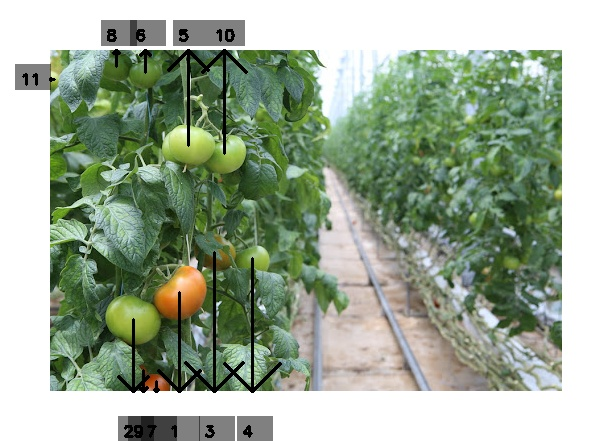

In [54]:
# critique & refine
refined_concept_list = detector._critique_and_refine_query(
    user_request = user_request_specific,
    original_concepts = specific_objects,
    
    labeled_image_path = labeled_image_path,
    objects_detected = detected_specific,
    model="o1"   
)
print("refined concept list:", refined_concept_list)

# second detection - selectively
def _normalized_list(xs):
    return sorted([x.strip().lower() for x in xs if x and x.strip()])

if _normalized_list(refined_concept_list) != _normalized_list(specific_objects) and len(refined_concept_list) > 0:
    print("refined list differs → running second pass...")
    detected_refined, labeled_refined_path = detector._run_detector(image_path, refined_concept_list)
    print(f"second-pass detections: {len(detected_refined)} | labeled: {labeled_refined_path}")

    # 최종 사용 결과 선택 (2차가 유의미하면 교체)
    final_detections = detected_refined
    final_labeled = labeled_refined_path
else:
    print("refinement not needed or identical → keep first pass.")
    final_detections = detected_specific
    final_labeled = labeled_image_path

# 상세 결과 출력
print("\nFinal detections:")
for num, label, bbox in final_detections:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] label: {label} | box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

try:
    display(Image.open(final_labeled))
except:
    pass

### 6. Validation Bounding Box predictions utilizing the VLM

점점 품에서 

In [55]:
def _validate_bboxes_with_llm(self, user_request, labeled_image_path, model="o1"):
        """
        Pass the labeled image to the LLM to filter bounding boxes 
        based on user request. Returns 'valid_numbers' list.
        """
        base64_labeled_image = encode_image(labeled_image_path)
        
        messages = [
            {"role": "system", "content": "You are an AI reviewing an object detection output.\n"
                                          "All detected objects have been marked with an arrow mapping to a corresponding number.\n"
                                          "The image contains arrows labeled with numbers pointing to specific objects.\n"
                                          "Your task is to identify the objects indicated by these arrows and determine whether each detected object is relevant to the user's query.\n"
                                          "For each numbered arrow:\n"
                                          "1. Identify the object being pointed to.\n"
                                          "2. Provide a brief description of the object (e.g., 'top-left cup with blue leaves', 'bottom-right cup with watermelon pattern', or 'background birdcage').\n"
                                          "3. Analyze whether the object is valid based on the context and the user's instructions.\n"
                                          "4. Provide a clear, step-by-step explanation for each object's validity decision.\n"                                          
                                          "Return a JSON object with the reasoning and list of valid numbers matching the user's request.\n"
                                          "Example output:\n"
                                          "{ \"reasoning\": <reasoning> , \"valid_numbers\": {object_num :\"object_name\"} }"
            },
            {"role": "user", "content": [
                {"type": "text", "text": f"The user's original request was: {user_request}"},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_labeled_image}", "detail": "high"}}
            ]
            }
        ]
        valid_numbers_json = self.vlm_tool.chat_completion(
            messages, 
            model=model,
            response_format={"type": "json_object"}
        )

        try:
            valid_numbers_data = json.loads(valid_numbers_json)
            return valid_numbers_data.get("valid_numbers", {})
        except json.JSONDecodeError:
            return []
ObjectDetectionTool._validate_bboxes_with_llm = _validate_bboxes_with_llm